In [1]:
## Import all necessary packages

#To define and simulate the model
using DifferentialEquations 

#To plot results
using PyPlot
using LaTeXStrings

In [2]:
# Model of differential equations compatible with DifferentialEquations.jl
function SEIR_v!(du, u, p, t)
    
    S, E, I, R, Sv, Iv = u #functions
    
    β, κ, γ, α, μ, N = p #parameters
    
    du[1] = dS = -β*S*Iv/N
    du[2] = dE = β*S*Iv/N - κ*E
    du[3] = dI = κ*E - γ*I
    du[4] = dR = γ*I
    
    du[5] = dSv = -α*Sv*I/N - μ*Sv
    du[6] = dIv = α*Sv*I/N - μ*Iv
    
end

# Auxiliar function to easily obtain the model results
function get_vars(sol)
   
    S = []
    E = []
    I = []
    R = []
    
    S_V = []
    I_V = []
    
    for item in sol.u
       
        append!(S, item[1])
        append!(E, item[2])
        append!(I, item[3])
        append!(R, item[4])
        
        append!(S_V, item[5])
        append!(I_V, item[6])
        
    end
    
    return S, E, I, R, S_V, I_V
    
end

# Basic reproductive number
function R_0(β, α, κ, γ, μ, N, Nv, S0, τ)
   
    return  β*α/ (γ*μ) * (S0/N^2) * (Nv/(μ*τ)) * (1-exp(-μ*τ))
    
end

#Auxiliar function to compute a meshgrid
function meshgrid(x, y)
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    return X, Y
end

# Auxiliar function that computes a run of the model for the given input parameters
function single_run(β, κ, γ, α, μ, N, Nv)
    
    N_years = 100

    t = 365 * N_years

    E0 = 0
    I0 = 0.01 * N
    S0 = N - I0
    R0 = 0

    Sv0 = Nv
    Iv0 = 0

    initial_conditions = [S0, E0, I0, R0, Sv0, Iv0]

    parameters = [β, κ, γ, α, μ, N]

    time = (0.0, t)

    dosetimes = [365.0 * i for i in 1 : N_years]

    affect!(integrator) = integrator.u[5] = Nv

    cb = PresetTimeCallback(dosetimes,affect!)

    prob = ODEProblem(SEIR_v!, initial_conditions, time, parameters)

    sol = solve(prob, RK4(), adaptative=false, dt=5e-2, saveat=1, maxiters=10^9, callback=cb)

    S, E, I, R, Sv, Iv = get_vars(sol);

    return S, E, I, R, Sv, Iv
    
end

single_run (generic function with 1 method)

In [3]:
β = 0.019964629210535656
κ = (1/4.468534327936427) / 365
γ = (1/13.816202329656981) / (365)
α = 0.0864354643995437 
μ = 0.02209272187095225 

N = 19417*81

E0 = 0
I0 = 0.01 * N
S0 = N - I0
R0 = 0

Iv0 = 0

τ = 365

Nvs = [10^i for i in 4.3 : 0.05 : 6.3]

mus = [10^i for i in -2 : 0.05 : 0]

R_infs = zeros((length(Nvs), length(mus)))

R0s = zeros((length(Nvs), length(mus)))

i = 0
j = 0

@time @inbounds for Nv in Nvs
    
    i += 1
    j = 0
    
    for µ in mus
        
        j += 1

        S, E, I, R, Sv, Iv = single_run(β, κ, γ, α, μ, N, Nv)

        R_infs[i,j] = R[end]/N
        
        R0s[i,j] = R_0(β, α, κ, γ, μ, N, Nv, S0, τ)
        
    end
    
end

Nvs_mesh, mus_mesh = meshgrid(Nvs, mus)

idxs_matrix = zeros((length(Nvs), length(mus), 2))

for i in 1:length(Nvs)
    
    for j in 1:length(mus)
   
        idxs_matrix[i, j, :] = [i, j]
        
    end
    
end

xs_DF = idxs_matrix[:, :, 1][R_infs .< 0.03] 
ys_DF = idxs_matrix[:, :, 2][R_infs .< 0.03]

ϵ_μ = 0.002
ϵ_Nv = 10000

x_current = idxs_matrix[:, :, 1][(mus_mesh .< μ + ϵ_μ) .& (mus_mesh .> μ - ϵ_μ) .& 
                                 (Nvs_mesh .< 786388.5 + ϵ_Nv) .& (Nvs_mesh .> 786388.5 - ϵ_Nv)]

y_current = idxs_matrix[:, :, 2][(mus_mesh .< μ + ϵ_μ) .& (mus_mesh .> μ - ϵ_μ) .& 
                                 (Nvs_mesh .< 786388.5 + ϵ_Nv) .& (Nvs_mesh .> 786388.5 - ϵ_Nv)]

distances = @. sqrt((xs_DF - x_current)^2 + (ys_DF - y_current)^2)

x_min = Int(xs_DF[argmin(distances)])
y_min = Int(ys_DF[argmin(distances)])

mus_R0s_1 = mus_mesh[(R0s .< 1.1) .& (R0s .> 0.9)]
Nvs_R0s_1 = Nvs_mesh[(R0s .< 1.1) .& (R0s .> 0.9)];

 38.560831 seconds (628.35 M allocations: 31.982 GiB, 7.89% gc time, 24.44% compilation time)


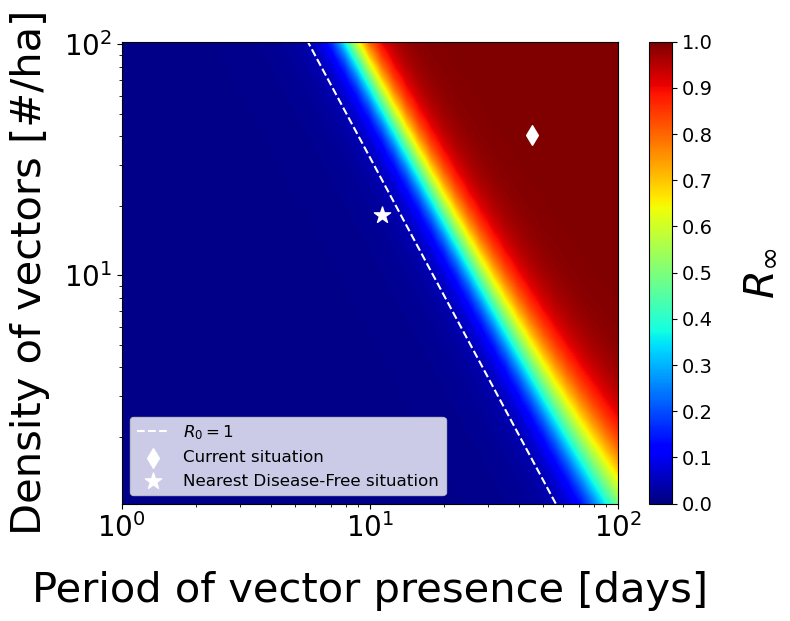

PyObject <matplotlib.legend.Legend object at 0x7f5526ee6c50>

In [4]:
clevels = range(0, stop=1, length=1000)

cbar_ticks = 0.0 : 0.1 : 1.0

plt.figure(figsize=(8, 6))

cnplot = plt.contourf(1 ./ mus, Nvs ./ 19417, R_infs, levels=clevels, cmap="jet")

plt.scatter([1 ./ μ], [81*0.5], color="white", marker="d", s=100, label="Current situation")

plt.scatter([1 ./ mus_mesh[x_min, y_min]], [Nvs_mesh[x_min, y_min] / 19417],
    color="white", marker="*", s=150, label="Nearest Disease-Free situation")


xx =  μ : 0.001 :  mus_mesh[x_min, y_min]

Δx = abs((1 ./ mus_mesh[x_min, y_min]) - (1 / μ))
Δy = (40.5) - (Nvs_mesh[x_min, y_min] / 19417)

slope =  Δy ./ Δx

#plt.plot(1 ./ xx, slope .* (1 ./ xx) .+  (1 ./ mus_mesh[x_min, y_min]), color="w", ls="--")

plt.plot(1.0 ./ mus_R0s_1[1:2:end], Nvs_R0s_1[1:2:end] / 19417, color="w", ls="--", label=L"$R_0=1$")

plt.yscale("log")
plt.xscale("log")

plt.xlabel("Period of vector presence [days]", fontsize=30, labelpad=20)
plt.ylabel("Density of vectors [#/ha]", fontsize=30, labelpad=10)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

cbar = plt.colorbar(cnplot, ticks=cbar_ticks)

cbar.set_label(L"$R_{\infty}$", fontsize=30, labelpad=20)
cbar.ax.tick_params(labelsize=14) 

plt.legend(loc="lower left", fontsize=12)